# Feature Extraction Methods Comparison Pipeline

This notebook compares four different feature extraction approaches:
1. PSVD on RGB images (90% variance)
2. PSVD on Grayscale images (95% variance)
3. SIFT feature extraction
4. HOG feature extraction

Each method is followed by K-means clustering and evaluation metrics comparison.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import warnings
import time
import os
from PIL import Image

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from skimage.feature import hog, SIFT
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

## Data Preprocessing

### Fix CSV Format

In [2]:
input_file = "C:\\Users\\Admin\\DATA\\fashion-dataset\\styles.csv"
output_file = "C:\\Users\\Admin\\DATA\\fashion-dataset\\data.csv"

with open(input_file, 'r', encoding='utf-8') as infile, open(output_file, 'w', encoding='utf-8', newline='') as outfile:
    reader = csv.reader(infile)
    writer = csv.writer(outfile)
    header = next(reader)
    writer.writerow(header)
    
    rows_fixed = 0
    for i, row in enumerate(reader, start=2):
        if len(row) == 10:
            writer.writerow(row)
        else:
            fixed_row = row[:9] + [', '.join(row[9:])]
            writer.writerow(fixed_row)
            rows_fixed += 1

print(f"CSV formatting complete. Fixed {rows_fixed} rows.")

CSV formatting complete. Fixed 22 rows.


### Extract Required Columns and Sample Data

In [3]:
undefined_images = [39403, 39410, 39401, 39425, 12347]
required_cols = ['id', 'masterCategory', 'subCategory']

df = pd.read_csv(output_file, usecols=required_cols)
df = df.loc[~df['id'].isin(undefined_images)].reset_index(drop=True)

top_16 = df['subCategory'].value_counts().nlargest(16).index
filtered = df[df['subCategory'].isin(top_16)]
df_sample = filtered.groupby('subCategory', group_keys=False).sample(n=477, random_state=42)

print(f"Total samples: {len(df_sample)}")
print(f"Subcategories: {df_sample['subCategory'].nunique()}")

Total samples: 7632
Subcategories: 16


## Configuration

In [4]:
image_dir = "C:\\Users\\Admin\\DATA\\fashion-dataset\\images"
target_size = (80, 60)
n_clusters = 16
random_state = 42

## Method 1: PSVD on RGB Images (90% Variance)

### Load and Preprocess RGB Images

In [5]:
image_data_rgb = []
valid_ids = []

for idx in df_sample['id'].values:
    img_path = os.path.join(image_dir, f"{idx}.jpg")
    if not os.path.exists(img_path):
        continue
    
    img = Image.open(img_path).convert('RGB')
    img_resized = img.resize(target_size, Image.Resampling.LANCZOS)
    img_array = np.array(img_resized, dtype=np.float64) / 255.0
    
    image_data_rgb.append(img_array.flatten())
    valid_ids.append(idx)

image_data_rgb = np.array(image_data_rgb)
df_valid = df_sample[df_sample['id'].isin(valid_ids)].reset_index(drop=True)

print(f"RGB image matrix shape: {image_data_rgb.shape}")

RGB image matrix shape: (7632, 14400)


### Apply PSVD (90% Variance)

In [6]:
start_time = time.time()

mean_rgb = np.mean(image_data_rgb, axis=0)
data_centered_rgb = image_data_rgb - mean_rgb

U_rgb, S_rgb, Vt_rgb = np.linalg.svd(data_centered_rgb, full_matrices=False)

variance_rgb = (S_rgb ** 2) / (data_centered_rgb.shape[0] - 1)
explained_variance_ratio_rgb = variance_rgb / np.sum(variance_rgb)
cumulative_variance_rgb = np.cumsum(explained_variance_ratio_rgb)

n_components_rgb_90 = np.argmax(cumulative_variance_rgb >= 0.90) + 1
variance_captured_rgb = cumulative_variance_rgb[n_components_rgb_90 - 1]

Vt_reduced_rgb = Vt_rgb[:n_components_rgb_90, :]
features_rgb_90 = np.dot(data_centered_rgb, Vt_reduced_rgb.T)

time_rgb_90 = time.time() - start_time

print(f"Components (90% variance): {n_components_rgb_90}")
print(f"Variance captured: {variance_captured_rgb:.4f}")
print(f"Feature shape: {features_rgb_90.shape}")
print(f"Processing time: {time_rgb_90:.2f}s")

Components (90% variance): 143
Variance captured: 0.9002
Feature shape: (7632, 143)
Processing time: 475.92s


## Method 2: PSVD on Grayscale Images (95% Variance)

### Load and Preprocess Grayscale Images

In [7]:
image_data_gray = []

for idx in valid_ids:
    img_path = os.path.join(image_dir, f"{idx}.jpg")
    img = Image.open(img_path).convert('L')
    img_resized = img.resize(target_size, Image.Resampling.LANCZOS)
    img_array = np.array(img_resized, dtype=np.float64) / 255.0
    
    image_data_gray.append(img_array.flatten())

image_data_gray = np.array(image_data_gray)

print(f"Grayscale image matrix shape: {image_data_gray.shape}")

Grayscale image matrix shape: (7632, 4800)


### Apply PSVD (95% Variance)

In [8]:
start_time = time.time()

mean_gray = np.mean(image_data_gray, axis=0)
data_centered_gray = image_data_gray - mean_gray

U_gray, S_gray, Vt_gray = np.linalg.svd(data_centered_gray, full_matrices=False)

variance_gray = (S_gray ** 2) / (data_centered_gray.shape[0] - 1)
explained_variance_ratio_gray = variance_gray / np.sum(variance_gray)
cumulative_variance_gray = np.cumsum(explained_variance_ratio_gray)

n_components_gray_95 = np.argmax(cumulative_variance_gray >= 0.95) + 1
variance_captured_gray = cumulative_variance_gray[n_components_gray_95 - 1]

Vt_reduced_gray = Vt_gray[:n_components_gray_95, :]
features_gray_95 = np.dot(data_centered_gray, Vt_reduced_gray.T)

time_gray_95 = time.time() - start_time

print(f"Components (95% variance): {n_components_gray_95}")
print(f"Variance captured: {variance_captured_gray:.4f}")
print(f"Feature shape: {features_gray_95.shape}")
print(f"Processing time: {time_gray_95:.2f}s")

Components (95% variance): 300
Variance captured: 0.9501
Feature shape: (7632, 300)
Processing time: 70.26s


## Method 3: HOG Feature Extraction

### Extract HOG Features

In [11]:
start_time = time.time()

hog_features = []

for idx in valid_ids:
    img_path = os.path.join(image_dir, f"{idx}.jpg")
    img = Image.open(img_path).convert('L')
    img_resized = img.resize(target_size, Image.Resampling.LANCZOS)
    img_array = np.array(img_resized, dtype=np.float64)

    img_array = exposure.equalize_adapthist(img_array / 255.0)
    
    features = hog(
        img_array,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        feature_vector=True
    )
    
    hog_features.append(features)

features_hog = np.array(hog_features)
scaler_hog = StandardScaler()
features_hog = scaler_hog.fit_transform(features_hog)

time_hog = time.time() - start_time

print(f"HOG feature shape: {features_hog.shape}")
print(f"Processing time: {time_hog:.2f}s")

HOG feature shape: (7632, 1944)
Processing time: 232.53s


## K-means Clustering and Evaluation

### Apply K-means to All Methods

In [12]:
methods = {
    'PSVD RGB (90%)': features_rgb_90,
    'PSVD Grayscale (95%)': features_gray_95,
    'HOG': features_hog
}

results = {}

for method_name, features in methods.items():
    start_time = time.time()
    
    kmeans = KMeans(
        n_clusters=n_clusters,
        init='k-means++',
        random_state=random_state,
        n_init=10,
        max_iter=300
    )
    
    labels = kmeans.fit_predict(features)
    clustering_time = time.time() - start_time
    
    sc = silhouette_score(features, labels)
    ch = calinski_harabasz_score(features, labels)
    db = davies_bouldin_score(features, labels)
    inertia = kmeans.inertia_
    
    results[method_name] = {
        'labels': labels,
        'silhouette': sc,
        'calinski_harabasz': ch,
        'davies_bouldin': db,
        'inertia': inertia,
        'clustering_time': clustering_time,
        'n_features': features.shape[1]
    }

print("K-means clustering completed for all methods.")

K-means clustering completed for all methods.


### Results Comparison Table

In [13]:
comparison_data = []

for method_name, result in results.items():
    comparison_data.append({
        'Method': method_name,
        'Features': result['n_features'],
        'Silhouette': f"{result['silhouette']:.4f}",
        'Calinski-Harabasz': f"{result['calinski_harabasz']:.2f}",
        'Davies-Bouldin': f"{result['davies_bouldin']:.4f}",
        'Inertia': f"{result['inertia']:.2f}",
        'Clustering Time (s)': f"{result['clustering_time']:.2f}"
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df

,Method,Features,Silhouette,Calinski-Harabasz,Davies-Bouldin,Inertia,Clustering Time (s)
0,PSVD RGB (90%),143,0.1426,670.78,1.8571,2200426.50,1.11
1,PSVD Grayscale (95%),300,0.1355,628.85,1.9325,778602.45,1.70
2,HOG,1944,0.0704,261.26,2.8107,9796034.38,9.38


### Processing Time Comparison

In [14]:
time_data = [
    {'Method': 'PSVD RGB (90%)', 'Feature Extraction (s)': time_rgb_90},
    {'Method': 'PSVD Grayscale (95%)', 'Feature Extraction (s)': time_gray_95},
    {'Method': 'HOG', 'Feature Extraction (s)': time_hog}
]

time_df = pd.DataFrame(time_data)
time_df['Clustering Time (s)'] = [results[m]['clustering_time'] for m in time_df['Method']]
time_df['Total Time (s)'] = time_df['Feature Extraction (s)'] + time_df['Clustering Time (s)']

time_df

,Method,Feature Extraction (s),Clustering Time (s),Total Time (s)
0,PSVD RGB (90%),475.918237,1.107933,477.026170
1,PSVD Grayscale (95%),70.263664,1.699567,71.963232
2,HOG,232.534436,9.383676,241.918112


## Visualization

### Clustering Metrics Comparison

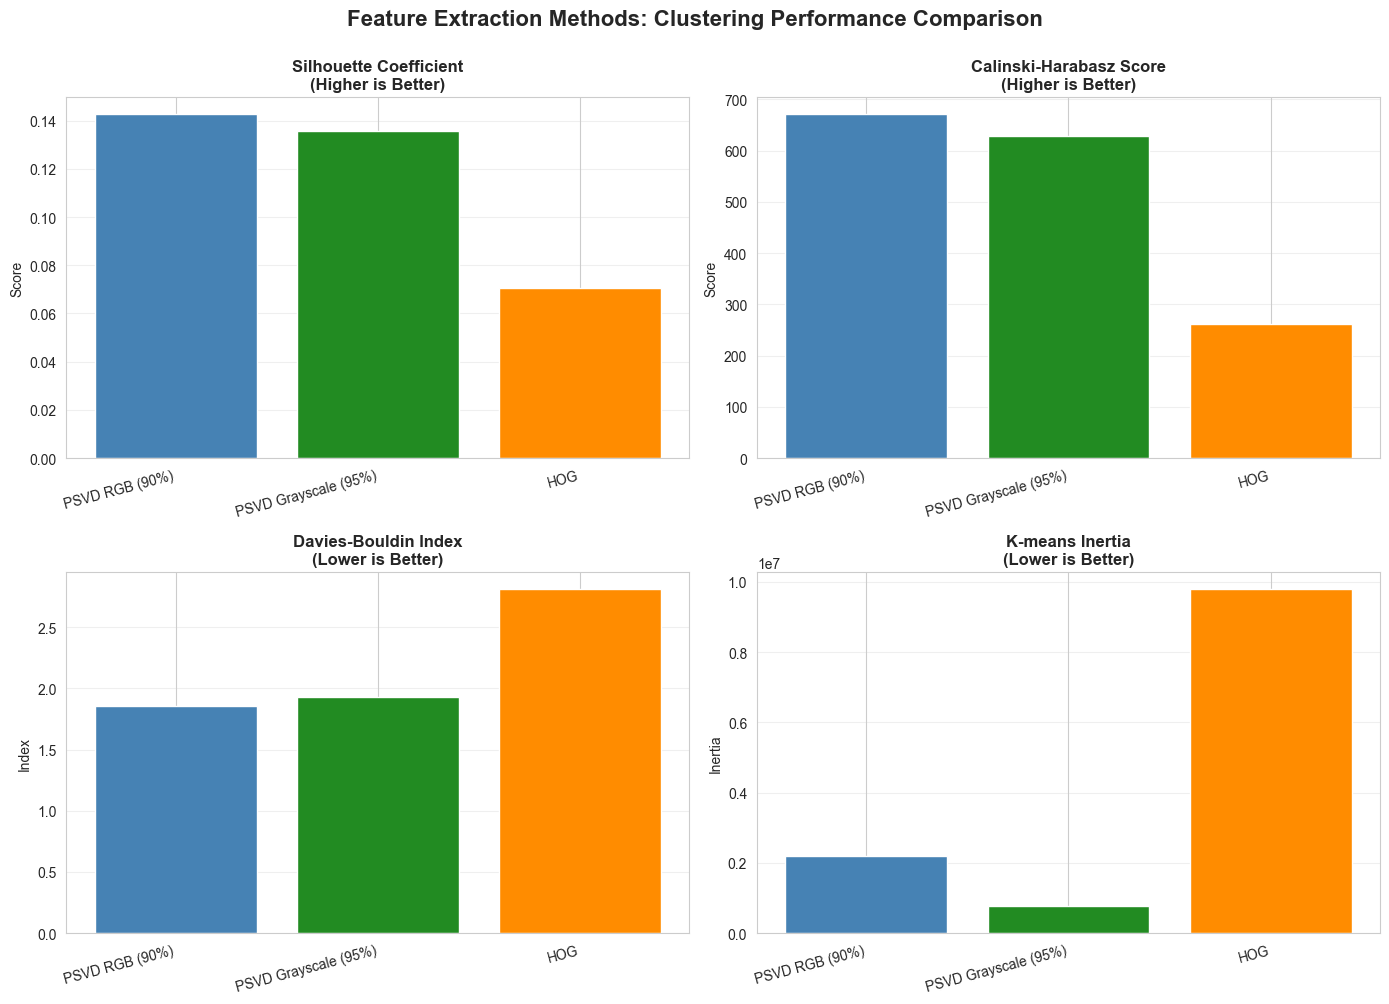

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

methods_list = list(results.keys())
colors = ['steelblue', 'forestgreen', 'darkorange', 'mediumpurple']

silhouette_scores = [results[m]['silhouette'] for m in methods_list]
axes[0, 0].bar(range(len(methods_list)), silhouette_scores, color=colors)
axes[0, 0].set_xticks(range(len(methods_list)))
axes[0, 0].set_xticklabels(methods_list, rotation=15, ha='right')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Silhouette Coefficient\n(Higher is Better)', fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

ch_scores = [results[m]['calinski_harabasz'] for m in methods_list]
axes[0, 1].bar(range(len(methods_list)), ch_scores, color=colors)
axes[0, 1].set_xticks(range(len(methods_list)))
axes[0, 1].set_xticklabels(methods_list, rotation=15, ha='right')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Calinski-Harabasz Score\n(Higher is Better)', fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

db_scores = [results[m]['davies_bouldin'] for m in methods_list]
axes[1, 0].bar(range(len(methods_list)), db_scores, color=colors)
axes[1, 0].set_xticks(range(len(methods_list)))
axes[1, 0].set_xticklabels(methods_list, rotation=15, ha='right')
axes[1, 0].set_ylabel('Index')
axes[1, 0].set_title('Davies-Bouldin Index\n(Lower is Better)', fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

inertia_scores = [results[m]['inertia'] for m in methods_list]
axes[1, 1].bar(range(len(methods_list)), inertia_scores, color=colors)
axes[1, 1].set_xticks(range(len(methods_list)))
axes[1, 1].set_xticklabels(methods_list, rotation=15, ha='right')
axes[1, 1].set_ylabel('Inertia')
axes[1, 1].set_title('K-means Inertia\n(Lower is Better)', fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.suptitle('Feature Extraction Methods: Clustering Performance Comparison', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('clustering_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### Processing Time Comparison

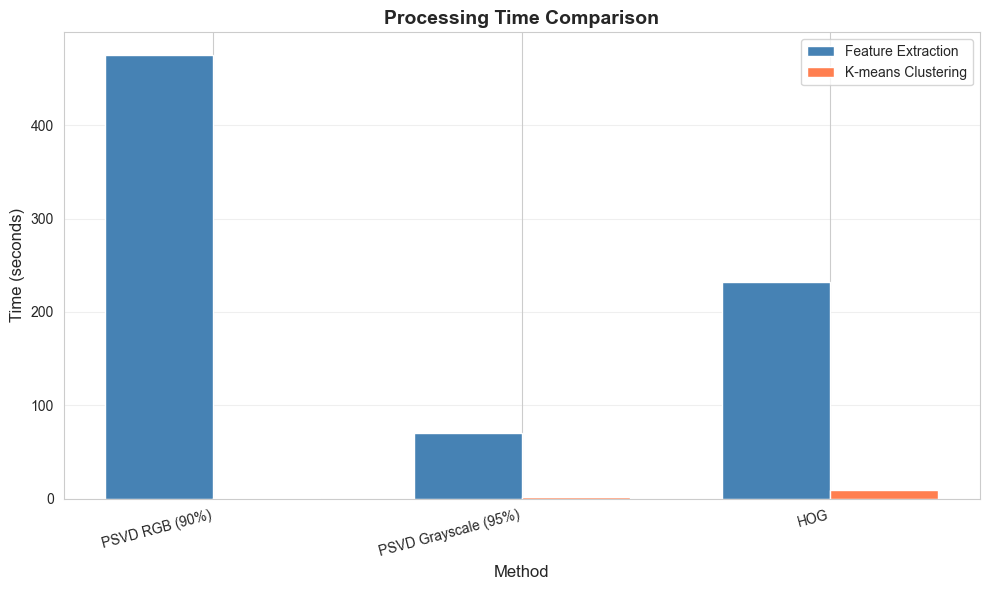

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(methods_list))
width = 0.35

extraction_times = time_df['Feature Extraction (s)'].values
clustering_times = time_df['Clustering Time (s)'].values

ax.bar(x - width/2, extraction_times, width, label='Feature Extraction', color='steelblue')
ax.bar(x + width/2, clustering_times, width, label='K-means Clustering', color='coral')

ax.set_xlabel('Method', fontsize=12)
ax.set_ylabel('Time (seconds)', fontsize=12)
ax.set_title('Processing Time Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods_list, rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('processing_time_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### Feature Dimensionality Comparison

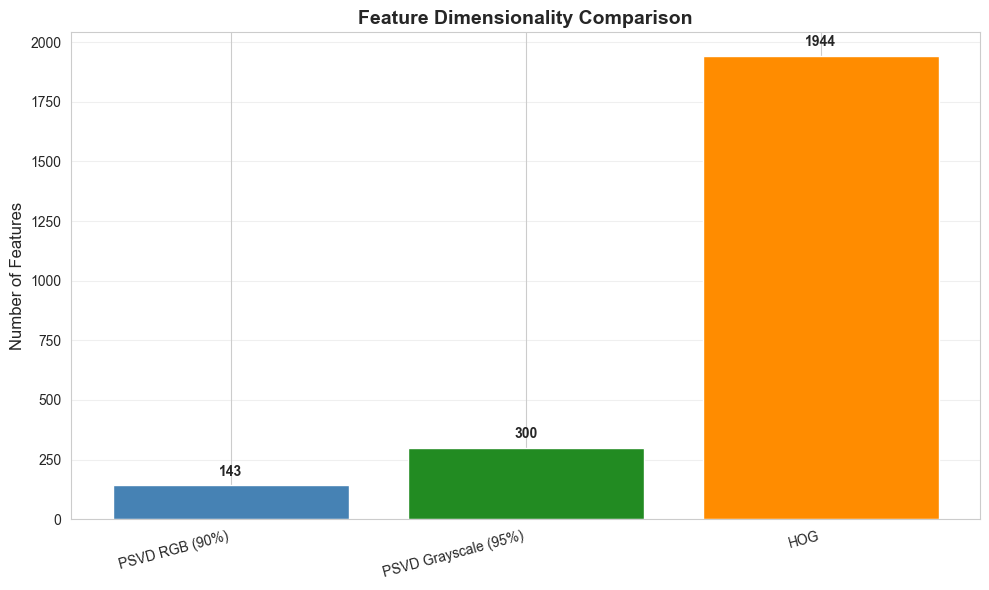

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

feature_dims = [results[m]['n_features'] for m in methods_list]

ax.bar(range(len(methods_list)), feature_dims, color=colors)
ax.set_xticks(range(len(methods_list)))
ax.set_xticklabels(methods_list, rotation=15, ha='right')
ax.set_ylabel('Number of Features', fontsize=12)
ax.set_title('Feature Dimensionality Comparison', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

for i, v in enumerate(feature_dims):
    ax.text(i, v + max(feature_dims)*0.02, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('feature_dimensionality_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Cluster Purity Analysis

### Calculate Purity for Each Method

In [18]:
true_labels = df_valid['subCategory'].values
purity_results = []

for method_name, result in results.items():
    cluster_labels = result['labels']
    total_correct = 0
    
    for cluster_id in range(n_clusters):
        mask = cluster_labels == cluster_id
        cluster_subcats = true_labels[mask]
        
        if len(cluster_subcats) > 0:
            subcats, counts = np.unique(cluster_subcats, return_counts=True)
            total_correct += counts.max()
    
    overall_purity = total_correct / len(cluster_labels)
    purity_results.append({
        'Method': method_name,
        'Overall Purity': f"{overall_purity:.4f}",
        'Percentage': f"{overall_purity*100:.2f}%"
    })

purity_df = pd.DataFrame(purity_results)
purity_df

,Method,Overall Purity,Percentage
0,PSVD RGB (90%),0.5063,50.63%
1,PSVD Grayscale (95%),0.4959,49.59%
2,HOG,0.5875,58.75%


### Visualize Cluster Purity

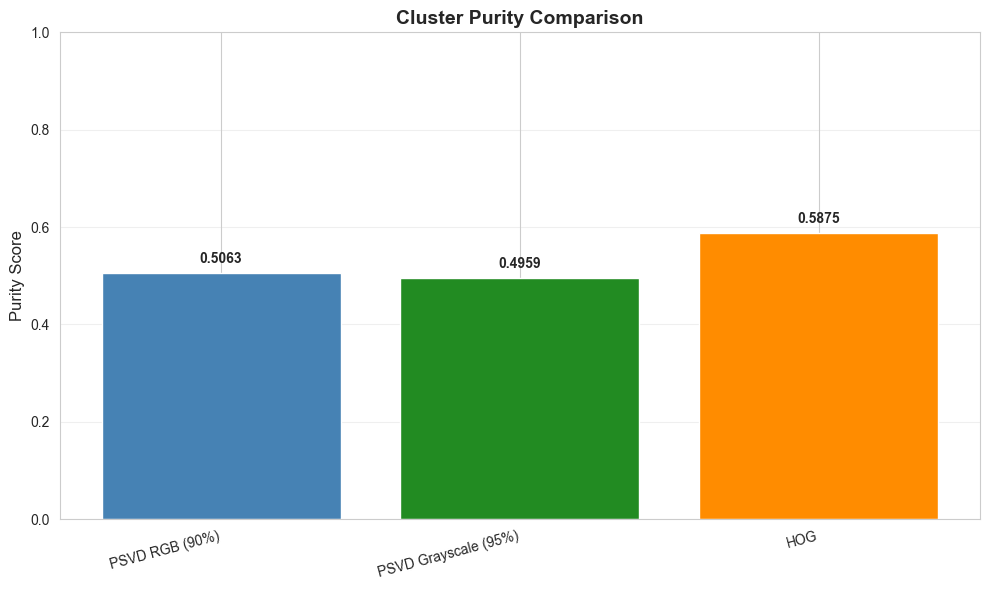

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

purity_values = [float(p['Overall Purity']) for p in purity_results]

ax.bar(range(len(methods_list)), purity_values, color=colors)
ax.set_xticks(range(len(methods_list)))
ax.set_xticklabels(methods_list, rotation=15, ha='right')
ax.set_ylabel('Purity Score', fontsize=12)
ax.set_title('Cluster Purity Comparison', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

for i, v in enumerate(purity_values):
    ax.text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('cluster_purity_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Summary

### Overall Performance Summary

In [20]:
summary_data = []

for i, method_name in enumerate(methods_list):
    summary_data.append({
        'Method': method_name,
        'Features': results[method_name]['n_features'],
        'Silhouette': f"{results[method_name]['silhouette']:.4f}",
        'CH Score': f"{results[method_name]['calinski_harabasz']:.2f}",
        'DB Index': f"{results[method_name]['davies_bouldin']:.4f}",
        'Purity': purity_results[i]['Percentage'],
        'Total Time (s)': f"{time_df.iloc[i]['Total Time (s)']:.2f}"
    })

summary_df = pd.DataFrame(summary_data)
summary_df

,Method,Features,Silhouette,CH Score,DB Index,Purity,Total Time (s)
0,PSVD RGB (90%),143,0.1426,670.78,1.8571,50.63%,477.03
1,PSVD Grayscale (95%),300,0.1355,628.85,1.9325,49.59%,71.96
2,HOG,1944,0.0704,261.26,2.8107,58.75%,241.92
